## Prepare Dependencies

In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

In [ ]:
!pip install datasets
from datasets import Dataset
!pip install ragas
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy
)

In [5]:
!pip install -U langchain-openai
!pip install openai
!pip install tiktoken
!pip install -U qdrant-client
!pip install langchain_experimental
!pip install "langchain[docarray]"

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 3.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 205.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 97.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googleapis-common-protos 1.63.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=

In [873]:
from openai import OpenAI
import httpx

#Set the langchain
import os
os.environ["OPENAI_API_BASE"] = 'https://api.xty.app/v1'
os.environ["OPENAI_API_KEY"] = 'sk-xARsvcz0Lu8vU8LzA8F845704f1d4c0180087e19137e0d2e'

In [8]:
from langchain.document_loaders import CSVLoader
from langchain_openai import OpenAIEmbeddings
from qdrant_client import QdrantClient
from langchain_community.vectorstores import Qdrant
from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

## Data Prepare

In [23]:
import pandas as pd
c1 = pd.read_csv("01-papers.csv")
c2 = pd.read_csv("02-papers.csv")
c3 = pd.read_csv("03-papers.csv")
c4 = pd.read_csv("04-papers.csv")
c5 = pd.read_csv("05-papers.csv")
c6 = pd.read_csv("06-papers.csv")
c7 = pd.read_csv("07-papers.csv")
c8 = pd.read_csv("08-papers.csv")
c9 = pd.read_csv("09-papers.csv")
c10 = pd.read_csv("10-papers.csv")

In [24]:
papers = pd.concat([c1,c2,c3,c4,c5,c6,c7,c8,c9,c10], axis=0)

In [25]:
papers['info'] = papers['author'].map(str) + papers['year'].map(str) + papers['title'].map(str)
data = papers.drop(columns = ['author','year','title'])
data.to_csv('001_DATA.csv')

,abstract,info
0,Background: Young adults are not considered a ...,A. E. Zysset; N. Schlatter; A. Von Wyl; M. Hub...
1,Objectives: Young adults have been overly affe...,A. Zysset; T. Volken; S. Amendola; A. von Wyl;...
2,Objectives: COVID-19 pandemic seems to be unde...,M. Zysman; J. Asselineau; O. Saut; E. Frison; ...
3,Objectives: Coronavirus illness (COVID-19) has...,S. H. Zyoud; M. Shakhshir; A. Koni; M. Shahwan...
4,Background: The term “human microbiota” refers...,S. H. Zyoud; M. Shakhshir; A. S. Abushanab; A....
...,...,...
16125,COVID-19 has upended medical practice and educ...,S. Moerdler; B. Gampel; J. M. Levine; A. Chou;...
16126,Introduction: This article reports on the effe...,M. R. Moentmann; J. Johnson; M. T. Chung; O. E...
16127,The Coronavirus disease 2019 (COVID-19) pandem...,M. Moens; R. V. Duarte; A. De Smedt; K. Putman...
16128,Background: Coronavirus Disease 2019 (COVID-19...,I. S. Moens; L. J. van Gerven; S. M. Debeij; C...


In [26]:
pd.set_option('max_colwidth', 700)
data

,abstract,info
0,"Background: Young adults are not considered a risk group, but the public health response to COVID-19 impacts all citizens. We investigated the impact on young adults' and their adherence to containment measures addressing potential gender differences. Methods: In April 2020 12 341 students of the Zurich University of Applied Sciences were invited to a longitudinal health survey. Survey topics spanned socio-demographic data, students' health status and behavior, COVID-19 specific impact, concerns, information sources, adherence to containment measures, and trust in government bodies. Group comparisons by gender and multivariate ordinal regression models assessing adherence to restrictions...",A. E. Zysset; N. Schlatter; A. Von Wyl; M. Huber; T. Volken; J. Dratva2021Students' experience and adherence to containment measures during COVID-19 in Switzerland
1,"Objectives: Young adults have been overly affected by the containment measures against COVID-19 and, consequently, worsening in mental health and change in health behavior have been reported. Because the life phase of emerging adulthood is crucial for developing health behaviors, this study aims to examine increase in alcohol consumption, single and multiple binge drinking, and associated factors in students during lockdown and post-lockdown periods. Methods: A prospective open cohort study design with nine survey time points between April 2020 and June 2021 was conducted. The present study uses pooled data from the first survey T0 (3 April to 14 April) and follow-ups at T1 (30 April to ...",A. Zysset; T. Volken; S. Amendola; A. von Wyl; J. Dratva2022Change in Alcohol Consumption and Binge Drinking in University Students During the Early COVID-19 Pandemic
2,"Objectives: COVID-19 pandemic seems to be under control. However, despite the vaccines, 5 to 10% of the patients with mild disease develop moderate to critical forms with potential lethal evolution. In addition to assess lung infection spread, chest CT helps to detect complications. Developing a prediction model to identify at-risk patients of worsening from mild COVID-19 combining simple clinical and biological parameters with qualitative or quantitative data using CT would be relevant to organizing optimal patient management. Methods: Four French hospitals were used for model training and internal validation. External validation was conducted in two independent hospitals. We used easy-...",M. Zysman; J. Asselineau; O. Saut; E. Frison; M. Oranger; A. Maurac; J. Charriot; R. Achkir; S. Regueme; E. Klein; S. Bommart; A. Bourdin; G. Dournes; J. Casteigt; A. Blum; G. Ferretti; B. Degano; R. Thiébaut; F. Chabot; P. Berger; F. Laurent; I. Benlala2023Development and external validation of a prediction model for the transition from mild to moderate or severe form of COVID-19
3,"Objectives: Coronavirus illness (COVID-19) has been found to alter infected people’s sense of smell and taste. However, the pathobiology of this virus is not yet known. Therefore, it is critical to investigate the influence of COVID-19 infection on olfactory and gustatory processes. Therefore, we use bibliometric analysis on COVID-19 and olfactory and/or gustatory dysfunction publications to provide studies perspective. Methods: A bibliometric literature search was performed in the Scopus database. The number and type of publications, countries for publications, institutional sources for publications, journals for publications, citation patterns, and funding agencies were analyzed using ...",S. H. Zyoud; M. Shakhshir; A. Koni; M. Shahwan; A. A. Jairoun; S. W. Al-Jabi2023Olfactory and Gustatory Dysfunction in COVID-19: A Global Bibliometric and Visualized Analysis
4,"Background: The term “human microbiota” refers to populations of microorganisms that live harmoniously in co-existence with humans. They contribute significantly to the host's immunological response when confronted with a respiratory viral infection. However, little is known 

In [27]:
loader = CSVLoader(file_path="001_DATA.csv", source_column="info")
data = loader.load()

In [28]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(data)
print('done.')

done.


In [63]:
# Take a look of your documents
print (f'Now you have {len(chunks)} documents')
print(chunks[90].page_content)

Now you have 538956 documents
during health care. Results: Of 875 people invited, 516 provided valid survey responses (59%). Their median age was 33 years (interquartile range, 26–45 years); 193 identified as women or trans women (37%), 185 as men or trans men (36%), and 138 as non-binary (27%). Of 448 respondents receiving gender-affirming hormone therapy, 230 (49%) reported disruptions to treatment during the pandemic; booked gender-affirming surgery had been cancelled or postponed for 37 of 85 respondents (44%). Trans-related discrimination during health care was reported by a larger proportion of participants than in a pre-pandemic survey (56% v 26%). COVID-19 was reported by 132 respondents (26%), of whom 49 reported health consequences three months or more after the acute illness (37%; estimated Australian rate: 5–10%). Three or more COVID-19 vaccine doses were reported by 448 participants (87%; Australian adult rate: 70%). Conclusions: High rates of COVID-19 vaccination among th

In [34]:
#Set an embedding model 
embeddings = OpenAIEmbeddings(model = 'text-embedding-3-small')

In [35]:
#Build a vector store 
story = Qdrant.from_documents(
    chunks,
    embeddings,
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="my_documents",
)

In [64]:
#Build a retriever
retriever = story.as_retriever(search_type="mmr") # Maximal marginal relevance 

In [116]:
documents = chunks

## Prompt

In [80]:
# Define LLM
llm = ChatOpenAI(model_name="gpt-4", temperature=0, max_tokens = 150)

# Define prompt template
template = """You are an expert for the COVID-19 fact-checking tasks.
Based on pieces of retrieved context to detect the claim is true or false. 
You will have to give me the title and author of the context you refered in one sentence. 
If you don't know the answer, just say that you don't know.
Keep the answer concise.
Claim: {question} 
Context: {context} 
Answer:
"""

prompt = ChatPromptTemplate.from_template(template)

In [990]:
retriever = retriever

In [82]:
# Setup RAG pipeline
#retriever = retriever11
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()} 
    | prompt 
    | llm
    | StrOutputParser() 
)
#compression_retriever_reordered

In [841]:
import pandas as pd
claim = pd.read_csv('500_g.csv')
claim

,question,ground_truths,answer,label
0,10. Investigations indicate that high-contact surfaces in public places are not a potential source of SARS-CoV-2 transmission.,False,NaN,NaN
1,"13. Data show that SARS-CoV-2 is not transmitted by speaking, coughing and sneezing.",False,NaN,1.0
2,"4. In earlier studies, the antiviral drug Favipiravir was effective in mild to moderate COVID-19 cases.",False,NaN,NaN
3,"11. A reduced risk of thromboembolic events has been observed in COVID-19 patients, indicating no systemic effects beyond respiratory problems.",False,NaN,NaN
4,17. Tooth pain and deterioration have not been detected in COVID-19 symptoms.,False,NaN,NaN
...,...,...,...,...
77,29. Enhanced awareness and documentation of novel COVID-19 symptoms can improve patient care and public health responses.,True,NaN,NaN
78,30. The dynamic nature of COVID-19 symptom reporting emphasizes the importance of continuous monitoring and research into the disease’s impact.,True,NaN,NaN
79,"4. One TGA patient included in the case reports tested negative for COVID-19, providing a contrastive viewpoint in the neurological study of the virus.",True,NaN,NaN
80,"8. Sputnik V, one of the COVID-19 vaccines studied, has reported instances of new adverse events post-vaccination.",True,NaN,NaN


## Baseline

In [72]:
# Define baseline LLM
llm_b = ChatOpenAI(model_name="gpt-4", temperature=0,max_tokens = 300)

# Define prompt template
template_b = """You are an expert for the COVID-19 fact-checking tasks. 
Please check the claim is true or false. 
If you don't know the answer, just say that you don't know. 
Use one sentences maximum and keep the answer concise.
Claim: {question} 
Answer:
"""

prompt_b = ChatPromptTemplate.from_template(template_b)

In [73]:
base_line = pd.read_csv('claim_e.csv')
base_line

,question,ground_truths
0,"Zinc water will NOT cure the novel coronavirus infection, because the zinc water contains quinine, and the synthetic hydroxychloroquine of quinine is being tested to treat the novel coronavirus infection.",True
1,Chewing raw Onions won't cure coronavirus.,True
2,The novel coronavirus can NOT be cured by drinking a bowl of freshly boiled garlic water.,True
3,American scientists have found a cure for the coronavirus.,True
4,Ginger ale is NOT an effective treatment for the 2019 novel coronavirus.,True
...,...,...
495,"It is false that ""the new coronavirus has already mutated a handful of times, but the new mutations are extremely similar to the original virus and don't seem to be any more aggressive.""",True
496,not only does covid-19 spread by contact with contaminated surfaces but new research finds that weather can influence how long the virus survives. scientists found that higher humidity could allow the virus to remain infectious longer.,True
497,people with cancer face a higher risk for covid-19. they must venture out into public to get treatment. plus the treatments can weaken their immune systems.,True
498,many of the symptoms of Lyme disease and covid-19 are nonspecific. that means a wide variety of health conditions may cause them.,True


In [74]:
rag_chain_b = (
    {"question": RunnablePassthrough()} 
    | prompt_b 
    | llm_b
    | StrOutputParser() 
)

In [75]:
questions = base_line['question']
ground_truths = base_line['ground_truths']
contexts = []
answers = []

# Inference
for query in questions:
    answers.append(rag_chain_b.invoke(query))

# To dict
data_b = {
    "question": questions,
    "answer": answers,
    "ground_truths": ground_truths
}

ValueError: The metric [answer_relevancy] that that is used requires the following additional columns ['contexts'] to be present in the dataset. 

In [76]:
# Convert dict to dataset
dataset_b = Dataset.from_dict(data_b)

tail = dataset_b.to_pandas()
tail.to_csv('gpt-4_b_e.csv')

In [77]:
tail

,question,answer,ground_truths
0,"Zinc water will NOT cure the novel coronavirus infection, because the zinc water contains quinine, and the synthetic hydroxychloroquine of quinine is being tested to treat the novel coronavirus infection.","False. Zinc water will not cure the novel coronavirus infection, but its ineffectiveness is not because it contains quinine; most zinc supplements or solutions do not contain quinine, and hydroxychloroquine's effectiveness against COVID-19 is not conclusively proven.",True
1,Chewing raw Onions won't cure coronavirus.,True.,True
2,The novel coronavirus can NOT be cured by drinking a bowl of freshly boiled garlic water.,True,True
3,American scientists have found a cure for the coronavirus.,False.,True
4,Ginger ale is NOT an effective treatment for the 2019 novel coronavirus.,"True, ginger ale is not an effective treatment for the 2019 novel coronavirus.",True
...,...,...,...
495,"It is false that ""the new coronavirus has already mutated a handful of times, but the new mutations are extremely similar to the original virus and don't seem to be any more aggressive.""","The claim is false; the new coronavirus has indeed mutated several times, with variants being similar to the original but their aggression varies.",True
496,not only does covid-19 spread by contact with contaminated surfaces but new research finds that weather can influence how long the virus survives. scientists found that higher humidity could allow the virus to remain infectious longer.,True.,True
497,people with cancer face a higher risk for covid-19. they must venture out into public to get treatment. plus the treatments can weaken their immune systems.,"True, people with cancer are at a higher risk for COVID-19 due to possible weakened immune systems and exposure during treatment.",True
498,many of the symptoms of Lyme disease and covid-19 are nonspecific. that means a wide variety of health conditions may cause them.,True,True


## Naive RAG

In [84]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [85]:
questions = claim['question']
ground_truths = claim['ground_truths']
contexts = []
answers = []

# Inference
for query in questions:
    answers.append(rag_chain.invoke(query))
    docs = retriever.invoke(query)
    contexts.append([docs.page_content for docs in retriever.invoke(query)])
    #contexts.append(docs[0].page_content)

# To dict
data = {
    "question": questions,
    "answer": answers,
    'contexts': contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

result = evaluate(
    dataset = dataset, 
    metrics=[
        answer_relevancy],
)

res = result.to_pandas()

Evaluating:  84%|████████▎ | 418/500 [13:37<02:40,  1.96s/it]
Exception in thread Thread-9:
Traceback (most recent call last):
  File "/environment/miniconda3/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/environment/miniconda3/lib/python3.10/site-packages/ragas/executor.py", line 96, in run
    results = self.loop.run_until_complete(self._aresults())
  File "/environment/miniconda3/lib/python3.10/asyncio/base_events.py", line 649, in run_until_complete
    return future.result()
  File "/environment/miniconda3/lib/python3.10/site-packages/ragas/executor.py", line 84, in _aresults
    raise e
  File "/environment/miniconda3/lib/python3.10/site-packages/ragas/executor.py", line 79, in _aresults
    r = await future
  File "/environment/miniconda3/lib/python3.10/asyncio/tasks.py", line 571, in _wait_for_one
    return f.result()  # May raise f.exception().
  File "/environment/miniconda3/lib/python3.10/site-packages/ragas/executor.py", line 38, in s

ExceptionInRunner: The runner thread which was running the jobs raised an exeception. Read the traceback above to debug it. You can also pass `raise_exceptions=False` incase you want to show only a warning message instead.

In [86]:
res = dataset.to_pandas()
res

,question,answer,contexts,ground_truths
0,"Zinc water will NOT cure the novel coronavirus infection, because the zinc water contains quinine, and the synthetic hydroxychloroquine of quinine is being tested to treat the novel coronavirus infection.","The claim is false. Although hydroxychloroquine, a synthetic of quinine, and zinc are both being tested for their potential in treating COVID-19, zinc water containing quinine will not necessarily cure the disease. Zinc and hydroxychloroquine have different ways of potentially affecting the virus and its effects on the body. \n\nReference: \n1. ""Does zinc supplementation enhance the clinical efficacy of chloroquine/hydroxychloroquine to win today's battle against COVID-19?"" by R. Derwand and M. Scholz\n2. ""A possible application of hinokitiol as a natural zinc ionophore and anti-infective agent for the prevention and treatment of COVID-19 and viral infections""","[abstract: Currently, drug repurposing is an alternative to novel drug development for the treatment of COVID-19 patients. The antimalarial drug chloroquine (CQ) and its metabolite hydroxychloroquine (HCQ) are currently being tested in several clinical studies as potential candidates to limit SARS-CoV-2-mediated morbidity and mortality. CQ and HCQ (CQ/HCQ) inhibit pH-dependent steps of SARS-CoV-2 replication by increasing pH in intracellular vesicles and interfere with virus particle delivery into host cells. Besides direct antiviral effects, CQ/HCQ specifically target extracellular zinc to intracellular lysosomes where it interferes with RNA-dependent RNA polymerase activity and coronav...",True
1,Chewing raw Onions won't cure coronavirus.,"True. The claim that ""chewing raw Onions won't cure coronavirus"" is correct. No document provided supports the idea that onions can cure COVID-19.\nNo specific document is referenced since none make the claim that onions cure COVID-19.","[abstract: The severity of coronavirus disease 2019 (COVID‐19) infection is quite variable and the manifestations varies from asymptomatic disease to severe acute respiratory infection. Fever, dry cough, dyspnea, myalgia, fatigue, loss of appetite, olfactory and gustatory dysfunctions are the most prevalent general symptoms. Decreased immune system cells such as suppressed regulatory T cells, cytotoxic and helper T cells, natural killer cells, monocytes/macrophages and increased proinflammatory cytokines are the characteristic features. Compounds derived from Allium sativum (garlic) have the potential to decrease the expression of proinflammatory cytokines and to reverse the immunologica...",True
2,The novel coronavirus can NOT be cured by drinking a bowl of freshly boiled garlic water.,"True. None of the provided documents mention garlic water as a cure for COVID-19. Refer to the document titled ""Broad Anti-Viral Capacities of Lian-Hua-Qing-Wen Capsule and Jin-Hua-Qing-Gan Granule and Rational use Against COVID-19 Based on Literature Mining"" by M. Shi et al., 2021, and others for more information on researched treatments.","[abstract: The novel coronavirus disease 2019 (COVID-19) has become a matter of international concern as the disease is spreading exponentially. Statistics showed that infected patients in China who received combined treatment of Traditional Chinese Medicine and modern medicine exhibited lower fatality rate and relatively better clinical outcomes. Both Lian-Hua-Qing-Wen Capsule (LHQWC) and Jin-Hua-Qing-Gan Granule (JHQGG) have been recommended by China Food and Drug Administration for the treatment of COVID-19 and have played a vital role in the prevention of a variety of viral infections. Here, we desired to analyze the broad-spectrum anti-viral capacities of LHQWC and JHQGG, and to com...",True
3,American scientists have found a cure for the coronavirus.,"The claim is false. There is no scientific paper or document that mentions a cure for the COVID-19 virus has been found by American scientists, based on the provided cont

In [87]:
res.to_csv('naive_rag_e.csv')

## Corrective RAG (CRAG)

In [991]:
# Implement the Router

import time
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
vectorstore = story
llm_w = ChatOpenAI(model="gpt-4", temperature=0)
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
    user question to a vectorstore or web search. Use the vectorstore for questions on COVID-19. 
    You do not need to be stringent with the keywords. 
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search' 
    or 'vectorstore' based on the question. 
    Return the a choice with a single key 'datasource' and no premable or explaination. 
    Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)
start = time.time()
question_router = prompt | llm_w | JsonOutputParser()
#
question = "High levels of a cytokine called interleukin-6 (IL-6) are not associated with respiratory failure and death in COVID-19 patients."
print(question_router.invoke({"question": question}))
end = time.time()
print(f"The time required to generate response by Router Chain in seconds:{end - start}")

{'datasource': 'vectorstore'}
The time required to generate response by Router Chain in seconds:4.087616682052612


In [992]:
# Implement the retrieval_grader

import time
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

# LLM with function call
llm = ChatOpenAI(model="gpt-4", temperature=0)

start = time.time()
retrieval_grader = prompt | llm | JsonOutputParser()

docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))
end = time.time()
print(f"The time required to generate response by the retrieval grader in seconds:{end - start}")

{'score': 'yes'}
The time required to generate response by the retrieval grader in seconds:9.483513832092285


In [993]:
## Implement the Generate Chain

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> 
    You are an expert for the COVID-19 fact-checking tasks.
    Based on pieces of retrieved context to detect the claim is true or false. 
    You will have to give me the title and author of the context you refered in one sentence.
    Use three sentences maximum and keep the answer concise.
    If you don't know the answer, just say that you don't know. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Context: {context} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# LLM
llm_g = ChatOpenAI(model_name="gpt-4", temperature=0)

# Chain
start = time.time()
rag_chain = prompt | llm_g | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

The claim is false. High levels of IL-6 are indeed associated with respiratory failure and death in COVID-19 patients. This is supported by the study "Deciphering the balance of IL-6/IL-10 cytokines in severe to critical COVID-19 patients" by M. B. Azaiz, A. B. Jemaa, et al, and further confirmed by the study "Elevated interleukin-6 and adverse outcomes in COVID-19 patients: a meta-analysis based on adjusted effect estimates" by P. Zhang, L. Shi, J. Xu, Y. Wang, and H. Yang.



In [994]:
# Implement the hallucination grader

# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)
start = time.time()
hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader_response = hallucination_grader.invoke({"documents": docs, "generation": generation})

end = time.time()
print(f"The time required to generate response by the generation chain in seconds:{end - start}")
print(hallucination_grader_response)

The time required to generate response by the generation chain in seconds:2.590351104736328
{'score': 'yes'}


In [995]:
### Answer Grader

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)
start = time.time()
answer_grader = prompt | llm | JsonOutputParser()
answer_grader_response = answer_grader.invoke({"question": question,"generation": generation})
end = time.time()
print(f"The time required to generate response by the answer grader in seconds:{end - start}")
print(answer_grader_response)

The time required to generate response by the answer grader in seconds:2.0904452800750732
{'score': 'yes'}


In [996]:
# Implement Web Search tool

import os
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
os.environ['TAVILY_API_KEY'] = "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"
#search = TavilySearchAPIWrapper()

web_search_tool = TavilySearchResults(k=3)

## Define the Graph State

In [997]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    question : str
    generation : str
    web_search : str
    documents : List[str]

In [998]:
## Define nodes 

from langchain.schema import Document
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}
#
def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}
#
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
#
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}
#

In [999]:
## Define edges 

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [1000]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [1001]:
## Add nodes 

from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

In [1002]:
## Set the Entry Point and End Point

workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [1003]:
## Compile the workflow

app = workflow.compile()

In [1004]:
## Test the workflow

from pprint import pprint
inputs = {"question": " Posts on social media claim the US Centers for Disease Control and Prevention (CDC) has revised down its death toll for COVID-19."}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
 Posts on social media claim the US Centers for Disease Control and Prevention (CDC) has revised down its death toll for COVID-19.
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('The claim that the US CDC revised down its death toll for COVID-19 is false. '
 'The context from the CDC website does not mention any revision down 

## Corrective RAG (CRAG) Performance

In [778]:
questions = claim['question']
ground_truths = claim['ground_truths']
contexts = []
answers = []

# Inference
for query in questions:
    inputs = {'question':query}
    try:
        for output in app.stream(inputs):
            for key, value in output.items():
                pprint(f"Finished running: {key}:")   
        answers.append(value["generation"])
        docs = retriever.invoke(query)
        contexts.append([docs.page_content for docs in retriever.invoke(query)])
    except (RuntimeError, TypeError, NameError, AttributeError,KeyError):
        continue
    #contexts.append(docs[0].page_content)

---ROUTE QUESTION---
25. The immunomodulatory role and potential benefits of zinc supplementation in the treatment of COVID-19 have NOT been explored.
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
'Finished running: generate:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GE

In [783]:
# To dict
data = {
    "question": questions,
    "answer": answers,
    'contexts': contexts,
    "ground_truths": ground_truths
}

In [784]:
data['answer']

['The claim is false. The immunomodulatory role and potential benefits of zinc supplementation in the treatment of COVID-19 have been explored. Specifically, studies have investigated how zinc deficiency might contribute to a poor prognosis, and the benefits of zinc supplementation to optimize immune function and reduce the risk of infection among the elderly. Furthermore, zinc has been reported to potentially prevent viral entry and suppress replication, suggesting potential benefits in the management of COVID-19. References used include "Immunomodulatory effects of zinc and its impact on COVID-19 severity" by M. Dhawan, T. B. Emran, and O. P. Choudhary and "The key role of zinc in elderly immunity: A possible approach in the COVID-19 crisis" by P. G. de Almeida Brasiel.',
 'The claim that the impact of ivermectin on COVID-19 outcomes has not been examined in detail due to study variability is false. Studies have indeed been conducted to assess the efficacy of ivermectin for COVID-19,

In [785]:
# Convert dict to dataset
#dataset = Dataset.from_dict(data)
res = pd.DataFrame(data['answer'])
res

,0
0,"The claim is false. The immunomodulatory role and potential benefits of zinc supplementation in the treatment of COVID-19 have been explored. Specifically, studies have investigated how zinc deficiency might contribute to a poor prognosis, and the benefits of zinc supplementation to optimize immune function and reduce the risk of infection among the elderly. Furthermore, zinc has been reported to potentially prevent viral entry and suppress replication, suggesting potential benefits in the management of COVID-19. References used include ""Immunomodulatory effects of zinc and its impact on COVID-19 severity"" by M. Dhawan, T. B. Emran, and O. P. Choudhary and ""The key role of zinc in elderl..."
1,"The claim that the impact of ivermectin on COVID-19 outcomes has not been examined in detail due to study variability is false. Studies have indeed been conducted to assess the efficacy of ivermectin for COVID-19, but evidence from those studies does not support its use, and issues with study quality have been noted. This is based on a systematic review and meta-analysis by A. Shafiee et al. (2022), as well as research by M. Popp et al. (2021) and A. Hill et al. (2022)."
2,"The claim is false. Bamlanivimab and etesevimab, administered together, are authorized for the treatment of mild-to-moderate COVID-19 in adults and pediatric patients as mentioned in the unidentified document."
3,"The claim is false. Studies have been conducted on Anakinra's potential to improve outcomes in severe COVID-19 cases, as indicated by the documents titled ""The Safety and Efficacy of Anakinra, an Interleukin-1 Antagonist in Severe Cases of COVID-19: A Systematic Review and Meta-Analysis"" and others reporting on clinical outcomes and EMA's expanded approval for its use in COVID-19. I don't have the specific authors' names from the provided context."
4,"The claim that the ability of nasal sprays containing antivirals or other protective agents to prevent transmission of COVID-19 has NOT been studied is false. Studies have been conducted to evaluate antimicrobial mouthwash and nasal sprays in suspected or confirmed COVID-19 patients, such as those referenced by M. J. Burton et al. (2020) and D. Zarabanda et al. (2022), and others have assessed the safety and potential utility of antiviral nasal sprays like astodrimer sodium as mentioned by A. Castellarnau et al. (2022). Additionally, research has been done on nasal sprays with the potential to prevent SARS-CoV-2 infection, as noted in the work by Lee, K. (2022) supported by the National ..."
...,...
141,"True. Enhanced awareness and documentation of novel COVID-19 symptoms can indeed improve patient care and public health responses. It facilitates prompt and accurate diagnosis, directs appropriate treatment, and provides critical information for public health officials as stated in the case report by J. D. Kline and A. E. Donovan. Additionally, unobserved or unspecified symptoms can delay disease detection as reported in a study by G. Torrell Vallespín and colleagues. Lastly, awareness increases the probability of patients seeking proper care and contributes to public health prevention actions as per the work of C. H. Basch and coauthors."
142,"The claim is supported by the context provided in ""Acute Symptoms of Mild to Moderate COVID-19 Are Highly Heterogeneous across Individuals and over Time"" by T. L. Rodebaugh et al., which emphasizes the heterogeneous and fluctuating course of COVID-19 symptoms. This indicates the necessity for ongoing monitoring and research to understand the disease’s impact fully. Additional studies are mentioned as needed to explore the connection between symptom patterns and long-term effects or disease deterioration."
143,"The claim is TRUE as one Transient Global Amnesia (TGA) patient included in the case reports did test negative for COVID-19, as suggested in the study, ""Transient global amnesia after COVID-19: A systematic scoping review of case reports"" by M. Farj

In [786]:
res.to_csv('self_rag_g_data.csv')

In [1009]:
## A test
app = workflow.compile()

#
inputs = {"question": '''

14. Discoloration of fingers or toes is an uncommon but noted symptom of COVID-19.

'''}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
value["generation"]

---ROUTE QUESTION---


14. Discoloration of fingers or toes is an uncommon but noted symptom of COVID-19.


{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'


'The claim that discoloration of fingers or toes is an uncommon but noted symptom of COVID-19 is true. The context from V. Comeau et al., 2020, in the article "Chilblains-Like Lesions as a Presenting Manifestation of Covid-19" confirms the occurrence of chilblains-like lesions in fingers and toes among COVID-19 patients. The study by C. Grover et al., 2022, titled "Nail Changes in COVID-19: A Cross Sectional Study From India," mentions nail discoloration as a common change reflecting systemic involvement of the illness. '

## Self RAG

In [804]:
### Retrieval Grader

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = claim['question'][0]
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [805]:
## Implement the Generate Chain

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> 
    You are an expert for the COVID-19 fact-checking tasks.
    Based on pieces of retrieved context to detect the claim is true or false. 
    You will have to give me the title and author of the context you refered in one sentence.
    Use three sentences maximum and keep the answer concise.
    If you don't know the answer, just say that you don't know. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Context: {context} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# LLM
llm_g = ChatOpenAI(model_name="gpt-4", temperature=0)

# Chain
start = time.time()
rag_chain = prompt | llm_g | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

The claim is false. The potential benefits of zinc supplementation in the treatment of COVID-19 have indeed been explored. This is supported by the studies "Potential role of zinc supplementation in prophylaxis and treatment of COVID-19" by Kubota, Chernov, and Kasuya, 2020, "The key role of zinc in elderly immunity: A possible approach in the COVID-19 crisis" by de Almeida Brasiel, 2020, and "Immunomodulatory effects of zinc and its impact on COVID-19 severity" by Dhawan, Emran, and Choudhary, 2022. These have investigated the impact of zinc for both prophylactic and therapeutic purposes. <|eot_id|>


In [806]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeDocuments(binary_score='yes')

In [808]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeDocuments(binary_score='yes')

In [810]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4", temperature=0)

# Prompt
system = """You a claim re-writer that converts an input claim to a better version that is optimized \n 
     for vectorstore retrieval and fact-checking. 
     Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial claim: \n\n {question} \n Formulate an improved claim.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Have the immunomodulatory effects and potential benefits of zinc supplementation in treating COVID-19 been investigated?'

## Graph State

In [811]:
from typing_extensions import TypedDict
from typing import List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [812]:
## Define nodes 

from langchain.schema import Document
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}
#
def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}
#
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}
#
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

#

In [813]:
## Define edges 

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [814]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [815]:
## Build Graph

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)



In [816]:
# Compile
app = workflow.compile()

## Self RAG Performance

In [953]:
## Test the workflow

from pprint import pprint
inputs = {"question": '''

7. Effective ventilation of indoor spaces can reduce the airborne spread of COVID-19.

'''}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

value["generation"]

---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Based on available evidence, the claim that effective ventilation of indoor '
 'spaces can reduce the airborne spread of COVID-19 is true. This is '
 'substantiated by studies such as "A review of strategies and their '
 'effectiveness in reducing indoor airborne transmission" by A. N. Nair, P. '
 'Anand, A. George, N. Mondal (2022) and "The impact of heating, ventilation, '
 'and air conditioning design features on the transmission of viruses" By G. '
 'M. Thornton, B. A. Fleck, E. K

'Based on available evidence, the claim that effective ventilation of indoor spaces can reduce the airborne spread of COVID-19 is true. This is substantiated by studies such as "A review of strategies and their effectiveness in reducing indoor airborne transmission" by A. N. Nair, P. Anand, A. George, N. Mondal (2022) and "The impact of heating, ventilation, and air conditioning design features on the transmission of viruses" By G. M. Thornton, B. A. Fleck, E. Kroeker, D. Dandnayak, N. Fleck, L. Zhong, L. Hartling (2022). Both of these studies emphasize employing effective ventilation strategies including airflow patterns, ventilation rates, and air change rate to minimize the viral spread in the built environment.'

In [848]:
data['answer']

["The claim is true. High-contact surfaces in public places are indeed low-risk for SARS-CoV-2 transmission, as suggested in the studies by 'I. J. Onakpoya; C. J. Heneghan; E. A. Spencer; J. Brassey; A. Plüddemann; D. H. Evans; J. M. Conly; T. Jefferson2021SARS-CoV-2 and the role of fomite transmission: a systematic review' and 'L. Gavaldà-Mestre; D. Ramírez-Tarruella; C. Gutiérrez-Milla; F. Guillamet-Roig; R. Orriols-Ramos; S. R. Tisner; N. Pàrraga-Niño2021Nondetection of SARS-CoV-2 on high-touch surfaces of public areas next to COVID-19 hospitalization units.' They found that most studies couldn't recover viable SARS-CoV-2 from such surfaces and SARS-CoV-2 was not detected in any sampled high-touch public area next to COVID-19 hospitalization units. These findings suggest low transmission risk.",
 'The claim that SARS-CoV-2 is not transmitted through speech, coughing, or sneezing is false. The context provided in the document authored by L. Comber et al., 2021 titled "Airborne transm

In [842]:
questions = claim['question']
ground_truths = claim['ground_truths']
contexts = []
answers = []

# Inference
for query in questions:
    inputs = {'question':query}
    try:
        for output in app.stream(inputs):
            for key, value in output.items():
                pprint(f"Finished running: {key}:")   
        answers.append(value["generation"])
        docs = retriever.invoke(query)
        contexts.append([docs.page_content for docs in retriever.invoke(query)])
    except (RuntimeError, TypeError, NameError, AttributeError,KeyError):
        continue
    #contexts.append(docs[0].page_content)

---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
'Finished running: grade_documents:'
---TRANSFORM QUERY---
'Finished running: transform_query:'
---RETRIEVE---
'Finished running: retrieve:'
---CHECK

KeyboardInterrupt: 

In [843]:
# To dict
data = {
    "question": questions,
    "answer": answers,
    'contexts': contexts,
    "ground_truths": ground_truths
}

In [844]:
# Convert dict to dataset
#dataset = Dataset.from_dict(data)
res = pd.DataFrame(data['answer'])
res

---GRADE: DOCUMENT RELEVANT---

,0
0,"The claim is true. High-contact surfaces in public places are indeed low-risk for SARS-CoV-2 transmission, as suggested in the studies by 'I. J. Onakpoya; C. J. Heneghan; E. A. Spencer; J. Brassey; A. Plüddemann; D. H. Evans; J. M. Conly; T. Jefferson2021SARS-CoV-2 and the role of fomite transmission: a systematic review' and 'L. Gavaldà-Mestre; D. Ramírez-Tarruella; C. Gutiérrez-Milla; F. Guillamet-Roig; R. Orriols-Ramos; S. R. Tisner; N. Pàrraga-Niño2021Nondetection of SARS-CoV-2 on high-touch surfaces of public areas next to COVID-19 hospitalization units.' They found that most studies couldn't recover viable SARS-CoV-2 from such surfaces and SARS-CoV-2 was not detected in any sampled..."
1,"The claim that SARS-CoV-2 is not transmitted through speech, coughing, or sneezing is false. The context provided in the document authored by L. Comber et al., 2021 titled ""Airborne transmission of SARS-CoV-2 via aerosols"" suggests that most transmission may occur through aerosols, especially in poorly ventilated environments. The second document by P. Z. Chen et al., 2021 titled ""Heterogeneity in transmissibility and shedding SARS-CoV-2 via droplets and aerosols"" indicates that while some individuals expel little virus, highly infectious individuals can expel a significant number of virus particles."
2,"The claim is true. The context provided from documents authored by T. Manabe, D. Kambayashi, H. Akatsu, K. Kudo in 2021, and J. H. McMahon among others in 2022, contains evidence of Favipiravir's efficacy in treating mild to moderate COVID-19 symptoms. The drug has been reported to induce viral clearance, contribute to clinical improvement, and inhibit SARS-CoV-2 replication."
3,"The claim is false. The studies from ""Macrovascular Thrombotic Events in a Mayo Clinic Enterprise-Wide Sample of Hospitalized COVID-19–Positive Compared With COVID-19–Negative Patients"" by authors R. Chaudhary, L. Padrnos, E. Wysokinska, et al., and ""Safety and efficacy of antithrombotics in outpatients with symptomatic COVID-19: A systematic review and meta-analysis"" by authors S. A. Ansari, N. Merza, M. Salman, et al., indicated that there is a risk, albeit lower than previously reported, of thrombotic events in COVID-19 patients, which contradicts the claim that there's a reduced risk. Additionally, antithrombotic drugs' risks and benefits in patients with mild to moderate COVID-19 sy..."
4,"The documents do not provide a clear link between COVID-19 symptoms and tooth pain or deterioration. The first document details a study about changes in permanent tooth injury in the Xi'an area of China during the COVID-19 pandemic, but this cannot definitively confirm if tooth pain or deterioration is a direct symptom of COVID-19 infection [""The impact of COVID-19 pandemic on the epidemiological characteristics of permanent dental injury in Xi'an of China: A retrospective study"" by Y. Yang; Y. Liu; Z. Wang; Q. Li; J. Wang; M. Zhang]. The second document discusses the potential links between periodontal disease and severe COVID-19 outcomes, but again, this doesn't affirm if tooth issues ..."
5,"The claim is false. Studies have demonstrated the importance of using genetic data alongside clinical and socio-demographic factors for a better understanding of severe COVID-19 outcomes. This information is cited from the study titled ""Interplay between demographic, clinical and polygenic risk factors for severe COVID-19"" by S. S. R. Crossfield, N. J. M. Chaddock, M. M. Iles, M. Pujades-Rodriguez, and A. W. Morgan (2022)."
6,"The claim is partially correct. According to a study by ""A. D. Flaxman; D. J. Henning; H. C. Duber"" titled ""The relative incidence of COVID-19 in healthcare workers versus non-healthcare workers"", the incidence rate of COVID-19 is lower in healthcare workers than in non-healthcare occupations. However, it should be noted that some reports like the study by ""N. A. Al-zoubi; B. R. Obeidat; M. A. Al-Ghazo"" titled ""Prevalence of positive

In [845]:
res.to_csv('self_rag_g_data.csv')

## Visualize the Agent / Graph

In [1011]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__[__start__]:::startclass;
	__end__[__end__]:::endclass;
	websearch([websearch]):::otherclass;
	retrieve([retrieve]):::otherclass;
	grade_documents([grade_documents]):::otherclass;
	generate([generate]):::otherclass;
	retrieve --> grade_documents;
	websearch --> generate;
	__start__ -.-> websearch;
	__start__ -. vectorstore .-> retrieve;
	grade_documents -.-> websearch;
	grade_documents -.-> generate;
	generate -. not supported .-> generate;
	generate -. useful .-> __end__;
	generate -. not useful .-> websearch;
	classDef startclass fill:#ffdfba;
	classDef endclass fill:#baffc9;
	classDef otherclass fill:#fad7de;



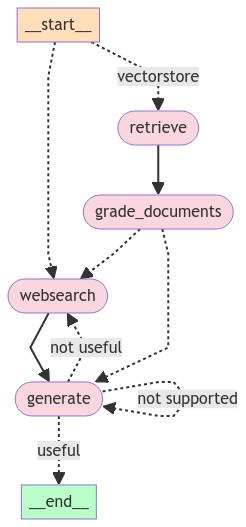

In [1012]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)